In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from datetime import datetime
from isoweek import Week
from cmdstanpy import CmdStanModel
from cmdstanpy import from_csv
import glob
import re

In [2]:
def best_draw_to_dict(row):
    result = {}
    for col in row.index:
        # attempt to match something like "paramName[123]"
        m = re.match(r"(.*)\[(\d+)\]$", col)
        if m:
            base_name = m.group(1)
            idx = int(m.group(2))  # 1-based index from Stan
            val = row[col]

            if base_name not in result:
                result[base_name] = {}
            result[base_name][idx] = val
        else:
            result[col] = row[col]

    for k, v in list(result.items()):
        if isinstance(v, dict):
            max_idx = max(v.keys())
            arr = np.empty(max_idx, dtype=float)
            for i in range(1, max_idx + 1):
                arr[i - 1] = v[i]
            result[k] = arr
    return result


In [3]:
# The parameters from the discrete-time fit are: 
#beta0 :		 mean transmission rate in units of 1/week
#dbeta :		 amplitude of sinusoidal transmission rate fluctuations
#betaphase :	 phase of sinusoidal transmission rate
#gamma :		 recovery rate in units of 1/week, this was assumed and not fitted
#mu :            birth/death rate in units of 1/week
#delta :		 immunity waning rate in units of 1/week. Equals 1/(duration of immunity)
#S0 :		     initial fraction susceptible
#I0 :		     initial fraction infected

csv_files = glob.glob('stan_output/sinusoid_2025/*20250404104108*.csv') # 
fit = from_csv(csv_files)
df_draws = fit.draws_pd()
lp = df_draws["lp__"]  # log posterior column
imax = np.argmax(lp)  # index of sample with highest lp__
best_draw = df_draws.iloc[imax]
best_draw_dict = best_draw_to_dict(best_draw)

beta0 = best_draw_dict['beta0']
dbeta = best_draw_dict['dbeta']
betaphase = best_draw_dict['betaphase']
gamma = 1/2.5
mu = 1/(80.0 * 52)
delta = best_draw_dict['delta']
S0 = best_draw_dict['S0']
I0 = best_draw_dict['I0']

# We must translate them into the continuous time version: 
def DiscRateToCont(r, dt):
    return (1 - np.exp(-r*dt))/dt

dt_discrete = 1/4
beta0 = DiscRateToCont(beta0 , dt_discrete)
gamma = DiscRateToCont(gamma, dt_discrete)
mu = DiscRateToCont(mu, dt_discrete)
delta = DiscRateToCont(delta, dt_discrete)

In [4]:
print(f"beta0 :\t\t {beta0} -- mean transmission rate in units of 1/week")
print(f"dbeta :\t\t {dbeta} -- amplitude of sinusoidal transmission rate fluctuations")
print(f"betaphase :\t {betaphase} -- phase of sinusoidal transmission rate")
print(f"gamma :\t\t {gamma} -- Recovery rate in units of 1/week")
print(f"mu :\t\t {mu} -- Birth/death rate in units of 1/week")
print(f"delta :\t\t {delta} -- Immunity waning rate in units of 1/week. Equals 1/(duration of immunity)")
print(f"S0 :\t\t {S0} -- initial fraction susceptible")
print(f"I0 :\t\t {I0} -- initial fraction infected")

beta0 :		 0.6911387031579177 -- mean transmission rate in units of 1/week
dbeta :		 0.188234 -- amplitude of sinusoidal transmission rate fluctuations
betaphase :	 3.61081 -- phase of sinusoidal transmission rate
gamma :		 0.38065032785616193 -- Recovery rate in units of 1/week
mu :		 0.00024037739243398804 -- Birth/death rate in units of 1/week
delta :		 0.0014941208808405548 -- Immunity waning rate in units of 1/week. Equals 1/(duration of immunity)
S0 :		 0.536414 -- initial fraction susceptible
I0 :		 0.00135138 -- initial fraction infected


In [5]:
import numpy as np
import numpy.linalg as LA

def sirs_ode(t, S, I, R, beta0, dbeta, betaphase, gamma, mu, delta):
    """
    Returns f(t, S, I, R) for the SIRS system
    """
    # time-dependent transmission
    beta_t = beta0 * (1 + dbeta*np.sin(2*np.pi*(t/52) + betaphase))
    dSdt = mu - beta_t*S*I - mu*S + delta*R
    dIdt = beta_t*S*I - (mu + gamma)*I
    dRdt = gamma*I - (mu + delta)*R
    return np.array([dSdt, dIdt, dRdt])

def sirs_jacobian(t, S, I, R, beta0, dbeta, betaphase, gamma, mu, delta):
    """
    Returns the 3x3 Jacobian matrix Df w.r.t (S, I, R)
    """
    # time-dependent transmission
    beta_t = beta0 * (1 + dbeta*np.sin(2*np.pi*(t/52) + betaphase))
    
    # build Jacobian
    J = np.zeros((3,3))
    # partial derivatives of dS/dt
    J[0,0] = -beta_t*I - mu
    J[0,1] = -beta_t*S
    J[0,2] = delta
    # partial derivatives of dI/dt
    J[1,0] = beta_t*I
    J[1,1] = beta_t*S - (mu + gamma)
    J[1,2] = 0.0
    # partial derivatives of dR/dt
    J[2,0] = 0.0
    J[2,1] = gamma
    J[2,2] = -(mu + delta)
    
    return J

def lyapunov_exponents_sirs(beta0, dbeta, betaphase, gamma, mu, delta, 
                            S0, I0, dt=0.05, total_time=20*52):
    """
    Compute the 3 Lyapunov exponents for the SIRS model over `total_time` weeks.
    `dt` is the Euler time step in units of weeks.
    """
    # number of steps
    N = int(total_time / dt)
    
    S, I, R = S0, I0, 1 - S0 - I0
    
    # set up 3 tangent vectors in R^3
    Q = np.eye(3)
    
    t = 0.0
    ts = []
    lyaps = np.zeros((3, N))
    for k in range(1, N+1):
        # compute the ODE derivatives
        f = sirs_ode(t, S, I, R, beta0, dbeta, betaphase, gamma, mu, delta)
        
        # Euler step for the base flow
        S += dt * f[0]
        I += dt * f[1]
        R += dt * f[2]
        
        # compute Jacobian at current step 
        J = sirs_jacobian(t, S, I, R, beta0, dbeta, betaphase, gamma, mu, delta)
        # tangent vector update: multiply each column of Q by [I + dt*J]
        M = np.eye(3) + dt*J
        Q = M @ Q  # matrix multiply
        
        # do QR decomposition
        Q, Rmat = np.linalg.qr(Q) 
        # accumulate the log stretch factors from diagonal of Rmat
        # (the sign of diag(Rmat) doesn’t matter for exponent, use absolute value)
        diag = np.abs(np.diag(Rmat))
        lyaps[:,k-1] = np.log(diag)/dt
        
        t += dt
        ts.append(t)
    
    return lyaps, np.array(ts)

dt = 0.001

LLEs, ts = lyapunov_exponents_sirs(beta0, dbeta, betaphase, gamma, mu, delta, 
                               S0, I0, dt=dt, total_time=10*52)
print("Estimated Lyapunov exponents:", LLEs)
print("Max LE =", np.max(LLEs))

years_to_expand = 2
ts_years = ts/52
print(f"Expansion over the first {years_to_expand} years:")
print(np.prod(np.exp(LLEs[0, ts_years <= years_to_expand] * dt)))
print(np.prod(np.exp(LLEs[1, ts_years <= years_to_expand] * dt)))
print(np.prod(np.exp(LLEs[2, ts_years <= years_to_expand] * dt)))

# Sub-sample the exponent time series -- no reason to have very temporally dense arrays:
LLEs = LLEs[:,::100]
ts = ts[::100]
ts_years = ts_years[::100]

Estimated Lyapunov exponents: [[-0.00109483 -0.00109507 -0.0010953  ...  0.00043606  0.00043706
   0.00043806]
 [-0.0416382  -0.04150029 -0.04136237 ... -0.02581536 -0.02581671
  -0.02581805]
 [-0.00180695 -0.00195187 -0.00209681 ... -0.02016512 -0.02017228
  -0.02017943]]
Max LE = 0.23792679280512102
Expansion over the first 2 years:
1.3382521980739401
9.97383172989006
0.11734140886963981


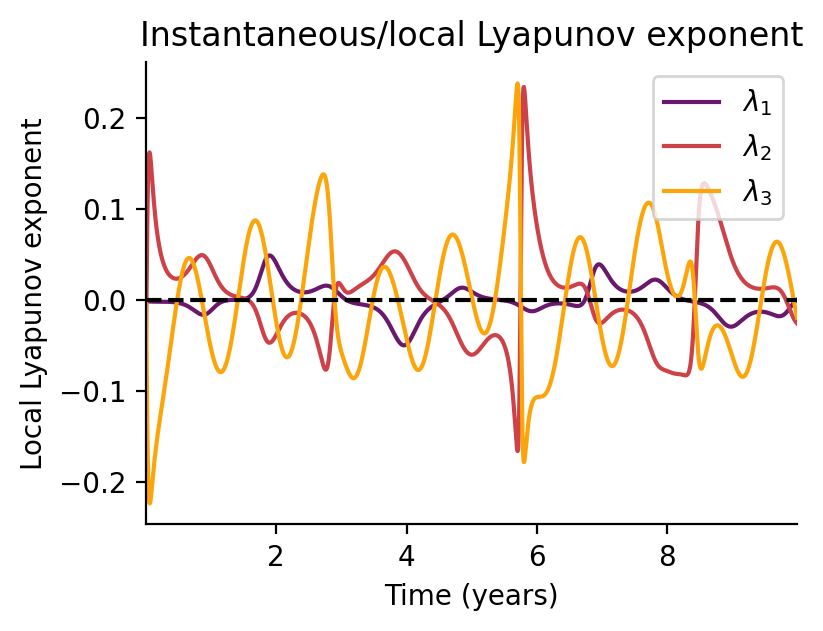

In [6]:
plt.figure(figsize=(4.2, 3), dpi=200)

import matplotlib.cm as cm
col1 = plt.cm.inferno(0.3)
col2 = plt.cm.inferno(0.55)
col3 = plt.cm.inferno(0.8)

#plt.plot(durations_yr, lya_t[0,:], label=r"$\lambda_S$")
plt.plot(ts_years, LLEs[0,:], label=r"$\lambda_1$", color=col1)
plt.plot(ts_years, LLEs[1,:], label=r"$\lambda_2$", color=col2)
plt.plot(ts_years, LLEs[2,:], label=r"$\lambda_3$", color=col3)
#plt.plot(durations_yr, lya_t[1,:], label=r"$\lambda_I$")
#plt.plot(durations_yr, lya_t[2,:], label=r"$\lambda_R$")
plt.plot(ts_years, [0] * len(ts), "--", color="black")
plt.xlim([ts_years[0],ts_years[-1] ])
plt.legend(loc="upper right")
#plt.xlabel("Years averaged over")
plt.ylabel("Local Lyapunov exponent")
plt.xlabel("Time (years)")
plt.title("Instantaneous/local Lyapunov exponent")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [7]:
lya_t = np.zeros((3, len(ts)))
for i, t_y in enumerate(ts):
    lya_t[0,i] = np.mean(LLEs[0, :i+1])
    lya_t[1,i] = np.mean(LLEs[1, :i+1])
    lya_t[2,i] = np.mean(LLEs[2, :i+1])

Mean lyap_1 during the first 2 years: 0.02211192131678963


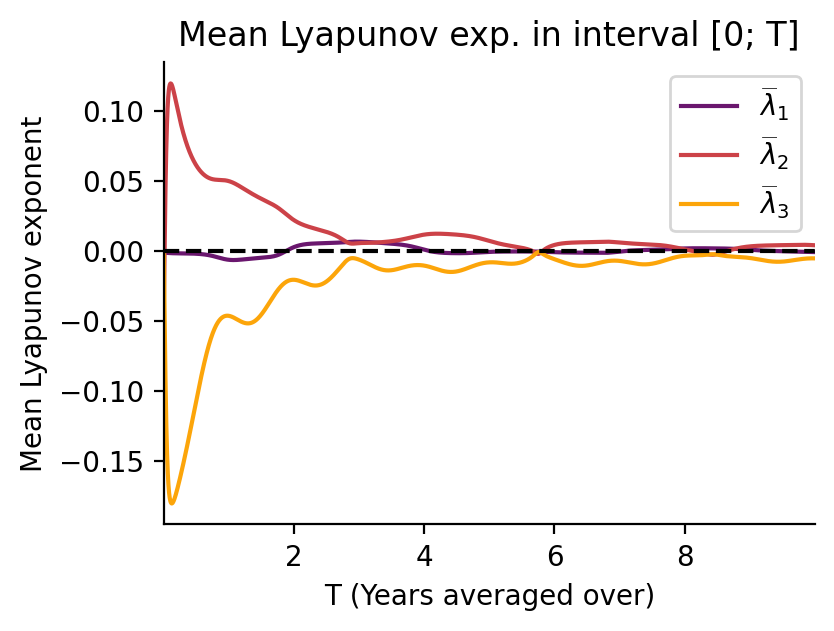

In [8]:
plt.figure(figsize=(4.2, 3), dpi=200)

plt.plot(ts_years, lya_t[0,:], label=r"$\widebar\lambda_1$", color=col1)
plt.plot(ts_years, lya_t[1,:], label=r"$\widebar\lambda_2$", color=col2)
plt.plot(ts_years, lya_t[2,:], label=r"$\widebar\lambda_3$", color=col3)
plt.plot(ts_years, [0] * len(ts_years), "--", color="black")
plt.xlim([ts_years[0],ts_years[-1] ])
plt.legend()
plt.xlabel("T (Years averaged over)")
plt.ylabel("Mean Lyapunov exponent")
plt.title("Mean Lyapunov exp. in interval [0; T]")

print("Mean lyap_1 during the first 2 years:", lya_t[1, ts_years<2][-1])

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Above was only for 2010 initial condition

# Across many initial conditions:

In [9]:
# Define initial conditions
IC_steps = 10
#IC_steps = 100
initial_conditions = [
    (S0, I0) for S0 in np.linspace(0, 1, IC_steps)  # Vary S0
    for I0 in np.logspace(-8, -2, IC_steps)              # Vary I0
    #(S0, I0) for S0 in np.linspace(0.5, 0.6, IC_steps)  # Vary S0
    #for I0 in np.logspace(-4, -2, IC_steps)              # Vary I0
    if S0 + I0 <= 1
]



In [ ]:
plt.figure(figsize=(4.2, 2.75), dpi=200)

it = 0
for S0, I0 in initial_conditions:
    dt = 0.05
    LLEs, ts = lyapunov_exponents_sirs(beta0, dbeta, betaphase, gamma, mu, delta, 
                                   S0, I0, dt=dt, total_time=10*52)
    LLEs = LLEs[:,::10]
    ts = ts[::10]
    ts_years = ts/52

    lya_t = np.zeros((3, len(ts)))
    for i, t_y in enumerate(ts_years):
        lya_t[0,i] = np.mean(LLEs[0, :i+1])
        lya_t[1,i] = np.mean(LLEs[1, :i+1])
        lya_t[2,i] = np.mean(LLEs[2, :i+1])
    imax = np.argsort(np.sum(lya_t, axis=1))[-1]
    if it==0:
        plt.plot(ts_years, lya_t[imax,:], label=r"$\widebar\lambda_\text{max}$", color=col1, alpha=1.0/IC_steps)
    else:
        plt.plot(ts_years, lya_t[imax,:], color=col1, alpha=1.0/IC_steps)
    it += 1

plt.plot(ts_years, [0] * len(ts_years), "--", color="black")
plt.xlim([ts_years[0],ts_years[-1] ])
plt.legend()
plt.xlabel("T (Years averaged over)")
plt.ylabel("Mean Lyapunov exponent")
#plt.title("Mean Lyapunov exp. in interval [0; T]")

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [ ]:
# Direct, rough measurement of expansion:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
@njit
def SIRS(beta, gamma, mu, delta, dbeta, betaphase, S0, I0):
    dt = 0.05
    #dt = 9.2
    T = int(20 * 52 * 1/dt) # 52 weeks * years / (time step size)
    R0 = 1 - S0 - I0
    S = np.zeros(T)
    I = np.zeros(T)
    R = np.zeros(T)
    t = np.zeros(T)
    S[0] = S0
    I[0] = I0
    R[0] = R0
    for i in range(1,T):
        t[i] = i*dt
        beta_t = beta * (1 + dbeta * np.sin(2 * np.pi * t[i]/52 + betaphase))
        dSdt = mu - beta_t * S[i - 1] * I[i - 1] - mu *  S[i - 1] + delta * R[i-1]
        dIdt = beta_t * S[i - 1] * I[i - 1] - (mu + gamma) *  I[i - 1]
        dRdt = gamma *  I[i - 1] - (mu+delta) *  R[i - 1]
        S[i] = S[i - 1] + dSdt * dt
        I[i] = I[i - 1] + dIdt * dt
        R[i] = R[i - 1] + dRdt * dt
    return t, S, I, R

In [ ]:
# Across many initial conditions:

In [ ]:
# Define initial conditions
IC_steps = 10
#IC_steps = 100
initial_conditions = [
    (S0, I0) for S0 in np.linspace(0.3, 0.7, IC_steps)  # Vary S0
    for I0 in np.logspace(-5, -1, IC_steps)              # Vary I0
    #(S0, I0) for S0 in np.linspace(0.5, 0.6, IC_steps)  # Vary S0
    #for I0 in np.logspace(-4, -2, IC_steps)              # Vary I0
    if S0 + I0 <= 1
]

In [ ]:

for (S0, I0) in initial_conditions:
    eps_I = 0.01*I0
    eps_S = 0.01*S0
    t, S1, I1, R1 = SIRS(beta0, gamma, mu, delta, dbeta, betaphase, S0, I0)
    t, S2, I2, R2 = SIRS(beta0, gamma, mu, delta, dbeta, betaphase, S0+eps_S, I0+eps_I)
    plt.plot(t/52, np.abs(I2-I1)/eps_I, color="red", alpha=0.2)
plt.yscale('log')

In [ ]:
for (S0, I0) in initial_conditions:
    eps_I = 0.01*I0
    eps_S = 0.01*S0
    t, S1, I1, R1 = SIRS(beta0, gamma, mu, delta, dbeta, betaphase, S0, I0)
    t, S2, I2, R2 = SIRS(beta0, gamma, mu, delta, dbeta, betaphase, S0+eps_S, I0+eps_I)
    plt.plot(t/52, np.abs(S2-S1)/eps_S, color="blue", alpha=0.2)
plt.yscale('log')